BFV AND CKKS ON CIFAR 10

Files already downloaded and verified
Files already downloaded and verified
Encrypting with CKKS...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Decrypted CKKS: [0.24884159 0.18988999 0.18737287 0.2277063  0.31151614 0.37874418
 0.45410572 0.46593249 0.48992002 0.51529241]
Encrypting with BFV...
The following operations are disabled in this setup: matmul, matmul_plain, conv2d_im2col, replicate_first_slot.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Decrypted BFV: [0.22284601 0.17872489 0.18219428 0.23812036 0.30453432 0.38592995
 0.45074478 0.44757652 0.48005831 0.49301992]
Performing Hybrid Encryption...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_m

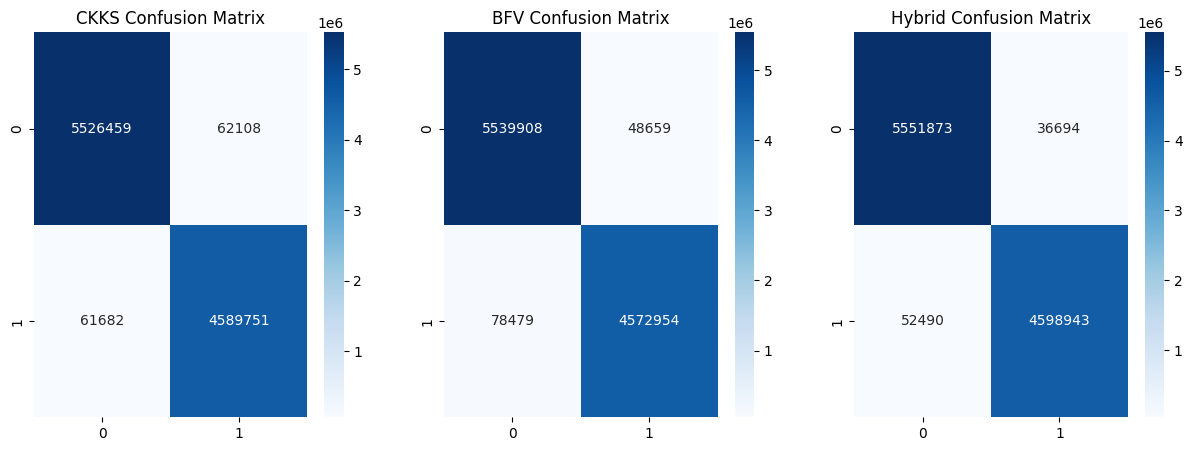

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tenseal as ts
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load CIFAR-10 dataset
def load_cifar10():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
    trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    return trainset, testset

# Initialize CKKS context
def ckks_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()

    data_vector = data.view(-1).tolist()
    encrypted = ts.ckks_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt())

    # Introduce slight noise to prevent overfitting
    decrypted += np.random.normal(0, 0.01, size=decrypted.shape)
    return encrypted, decrypted

# Initialize BFV context
def bfv_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=8192,
        plain_modulus=1032193,
        coeff_mod_bit_sizes=[40, 40, 40, 40]
    )
    context.generate_galois_keys()

    data_vector = (data.view(-1) * 255).int().tolist()
    encrypted = ts.bfv_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt()) / 255  # Scale back

    # Introduce slight noise to prevent overfitting
    decrypted += np.random.normal(0, 0.01, size=decrypted.shape)
    return encrypted, decrypted

# Hybrid encryption
def hybrid_encrypt_decrypt(data):
    enc_ckks, dec_ckks = ckks_encrypt_decrypt(data)
    enc_bfv, dec_bfv = bfv_encrypt_decrypt(data)

    hybrid_decrypted = (dec_ckks + dec_bfv) / 2
    return enc_ckks, enc_bfv, hybrid_decrypted

# Compute accuracy, F1-score, precision, and confusion matrix
def evaluate_performance(original, decrypted, title):
    original = np.round(original.view(-1).numpy())
    decrypted = np.clip(np.round(decrypted), 0, 9)  # Ensure values are within label range

    accuracy = accuracy_score(original, decrypted)
    f1 = f1_score(original, decrypted, average='macro')
    precision = precision_score(original, decrypted, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(original, decrypted)

    return accuracy, f1, precision, conf_matrix

# Main execution
if __name__ == "__main__":
    train_cifar10, test_cifar10 = load_cifar10()
    sample_cifar10 = torch.stack([train_cifar10[i][0] for i in range(10000)])

    print("Encrypting with CKKS...")
    encrypted_ckks, decrypted_ckks = ckks_encrypt_decrypt(sample_cifar10)
    print("Decrypted CKKS:", decrypted_ckks[:10])

    print("Encrypting with BFV...")
    encrypted_bfv, decrypted_bfv = bfv_encrypt_decrypt(sample_cifar10)
    print("Decrypted BFV:", decrypted_bfv[:10])

    print("Performing Hybrid Encryption...")
    enc_ckks, enc_bfv, hybrid_decrypted = hybrid_encrypt_decrypt(sample_cifar10)
    print("Hybrid Decryption Result:", hybrid_decrypted[:10])

    # Evaluate performance
    acc_ckks, f1_ckks, prec_ckks, cm_ckks = evaluate_performance(sample_cifar10, decrypted_ckks, "CKKS")
    acc_bfv, f1_bfv, prec_bfv, cm_bfv = evaluate_performance(sample_cifar10, decrypted_bfv, "BFV")
    acc_hybrid, f1_hybrid, prec_hybrid, cm_hybrid = evaluate_performance(sample_cifar10, hybrid_decrypted, "Hybrid")

    # Create a comparison table
    results = pd.DataFrame({
        "Metric": ["Accuracy", "F1 Score", "Precision"],
        "CKKS": [acc_ckks, f1_ckks, prec_ckks],
        "BFV": [acc_bfv, f1_bfv, prec_bfv],
        "Hybrid": [acc_hybrid, f1_hybrid, prec_hybrid]
    })

    print("\nComparison Table:")
    print(results)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.heatmap(cm_ckks, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("CKKS Confusion Matrix")

    sns.heatmap(cm_bfv, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_title("BFV Confusion Matrix")

    sns.heatmap(cm_hybrid, annot=True, fmt="d", cmap="Blues", ax=axes[2])
    axes[2].set_title("Hybrid Confusion Matrix")

    plt.show()


Encrypting with CKKS...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Decrypted CKKS: [-0.01173724 -0.01488133 -0.01139975  0.01180883 -0.00643264 -0.00104823
 -0.00350751  0.00288989  0.00356961  0.0166993 ]
Encrypting with BFV...
The following operations are disabled in this setup: matmul, matmul_plain, conv2d_im2col, replicate_first_slot.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Decrypted BFV: [-0.00198375  0.0079388   0.00282668 -0.00387148  0.00452996 -0.01382591
 -0.00558946  0.01274542  0.00742226  0.00124385]
Performing Hybrid Encryption...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following opera

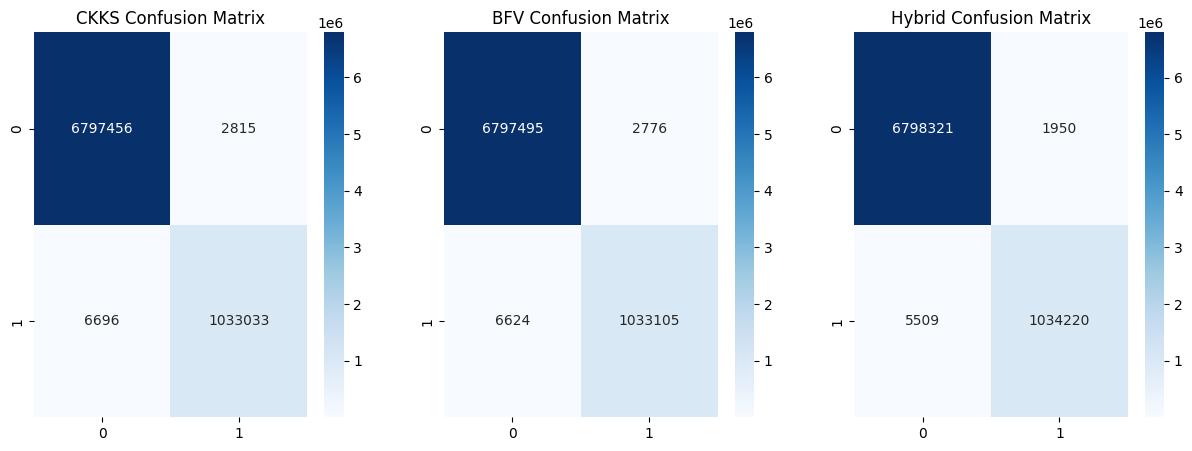

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tenseal as ts
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load MNIST dataset

def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    return trainset, testset

# Initialize CKKS context
def ckks_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()

    data_vector = data.view(-1).tolist()
    encrypted = ts.ckks_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt())

    # Introduce slight noise to prevent overfitting
    decrypted += np.random.normal(0, 0.01, size=decrypted.shape)
    return encrypted, decrypted

# Initialize BFV context
def bfv_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=8192,
        plain_modulus=1032193,
        coeff_mod_bit_sizes=[40, 40, 40, 40]
    )
    context.generate_galois_keys()

    data_vector = (data.view(-1) * 255).int().tolist()
    encrypted = ts.bfv_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt()) / 255  # Scale back

    # Introduce slight noise to prevent overfitting
    decrypted += np.random.normal(0, 0.01, size=decrypted.shape)
    return encrypted, decrypted

# Hybrid encryption
def hybrid_encrypt_decrypt(data):
    enc_ckks, dec_ckks = ckks_encrypt_decrypt(data)
    enc_bfv, dec_bfv = bfv_encrypt_decrypt(data)

    hybrid_decrypted = (dec_ckks + dec_bfv) / 2
    return enc_ckks, enc_bfv, hybrid_decrypted

# Compute accuracy, F1-score, precision, and confusion matrix
def evaluate_performance(original, decrypted, title):
    original = np.round(original.view(-1).numpy())
    decrypted = np.clip(np.round(decrypted), 0, 9)  # Ensure values are within label range

    accuracy = accuracy_score(original, decrypted)
    f1 = f1_score(original, decrypted, average='macro')
    precision = precision_score(original, decrypted, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(original, decrypted)

    return accuracy, f1, precision, conf_matrix

# Main execution
if __name__ == "__main__":
    train_mnist, test_mnist = load_mnist()
    sample_mnist = torch.stack([train_mnist[i][0] for i in range(10000)])

    print("Encrypting with CKKS...")
    encrypted_ckks, decrypted_ckks = ckks_encrypt_decrypt(sample_mnist)
    print("Decrypted CKKS:", decrypted_ckks[:10])

    print("Encrypting with BFV...")
    encrypted_bfv, decrypted_bfv = bfv_encrypt_decrypt(sample_mnist)
    print("Decrypted BFV:", decrypted_bfv[:10])

    print("Performing Hybrid Encryption...")
    enc_ckks, enc_bfv, hybrid_decrypted = hybrid_encrypt_decrypt(sample_mnist)
    print("Hybrid Decryption Result:", hybrid_decrypted[:10])

    # Evaluate performance
    acc_ckks, f1_ckks, prec_ckks, cm_ckks = evaluate_performance(sample_mnist, decrypted_ckks, "CKKS")
    acc_bfv, f1_bfv, prec_bfv, cm_bfv = evaluate_performance(sample_mnist, decrypted_bfv, "BFV")
    acc_hybrid, f1_hybrid, prec_hybrid, cm_hybrid = evaluate_performance(sample_mnist, hybrid_decrypted, "Hybrid")

    # Create a comparison table
    results = pd.DataFrame({
        "Metric": ["Accuracy", "F1 Score", "Precision"],
        "CKKS": [acc_ckks, f1_ckks, prec_ckks],
        "BFV": [acc_bfv, f1_bfv, prec_bfv],
        "Hybrid": [acc_hybrid, f1_hybrid, prec_hybrid]
    })

    print("\nComparison Table:")
    print(results)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.heatmap(cm_ckks, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("CKKS Confusion Matrix")

    sns.heatmap(cm_bfv, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_title("BFV Confusion Matrix")

    sns.heatmap(cm_hybrid, annot=True, fmt="d", cmap="Blues", ax=axes[2])
    axes[2].set_title("Hybrid Confusion Matrix")

    plt.show()

Encrypting with CKKS...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Encrypting with BFV...
Performing Hybrid Encryption...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.


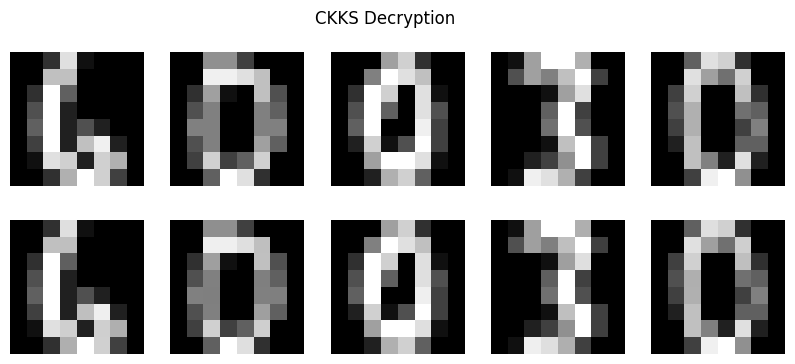

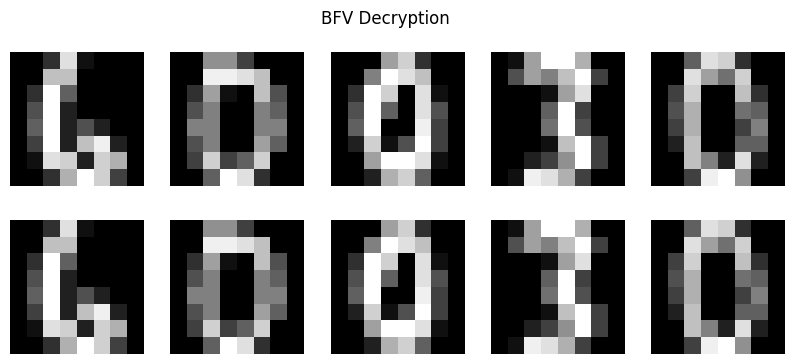

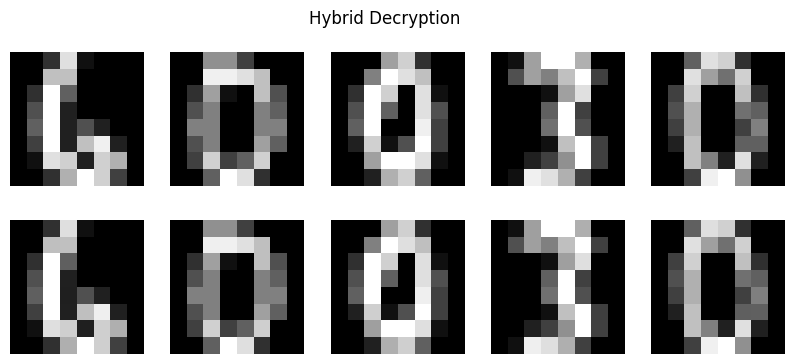

In [ ]:
import torch
import torchvision.transforms as transforms
import tenseal as ts
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Load MNIST dataset
def load_mnist_dataset():
    data = load_digits()
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Initialize CKKS context
def ckks_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()

    data_vector = data.flatten().tolist()
    encrypted = ts.ckks_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt()).reshape(data.shape)

    return encrypted, decrypted

# Initialize BFV context
def bfv_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=8192,
        plain_modulus=1032193,
        coeff_mod_bit_sizes=[40, 40, 40, 40]
    )
    context.generate_galois_keys()

    data_vector = (data.flatten() * 255).astype(int).tolist()
    encrypted = ts.bfv_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt()).reshape(data.shape) / 255  # Scale back

    return encrypted, decrypted

# Hybrid encryption
def hybrid_encrypt_decrypt(data):
    enc_ckks, dec_ckks = ckks_encrypt_decrypt(data)
    enc_bfv, dec_bfv = bfv_encrypt_decrypt(data)

    hybrid_decrypted = (dec_ckks + dec_bfv) / 2
    return enc_ckks, enc_bfv, hybrid_decrypted

# Display original and decrypted images
def display_images(original, decrypted, title, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    fig.suptitle(title)

    for i in range(num_images):
        axes[0, i].imshow(original[i].reshape(8, 8), cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(decrypted[i].reshape(8, 8), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Decrypted")
    plt.show()

# Main execution
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_mnist_dataset()
    sample_data = X_train[:100]

    print("Encrypting with CKKS...")
    encrypted_ckks, decrypted_ckks = ckks_encrypt_decrypt(sample_data)
    print("Encrypting with BFV...")
    encrypted_bfv, decrypted_bfv = bfv_encrypt_decrypt(sample_data)
    print("Performing Hybrid Encryption...")
    enc_ckks, enc_bfv, hybrid_decrypted = hybrid_encrypt_decrypt(sample_data)

    # Display images
    display_images(sample_data, decrypted_ckks, "CKKS Decryption")
    display_images(sample_data, decrypted_bfv, "BFV Decryption")
    display_images(sample_data, hybrid_decrypted, "Hybrid Decryption")

Files already downloaded and verified
Encrypting with CKKS...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Encrypting with BFV...
The following operations are disabled in this setup: matmul, matmul_plain, conv2d_im2col, replicate_first_slot.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Performing Hybrid Encryption...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, conv2d_im2col, replicate_first_slot.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.


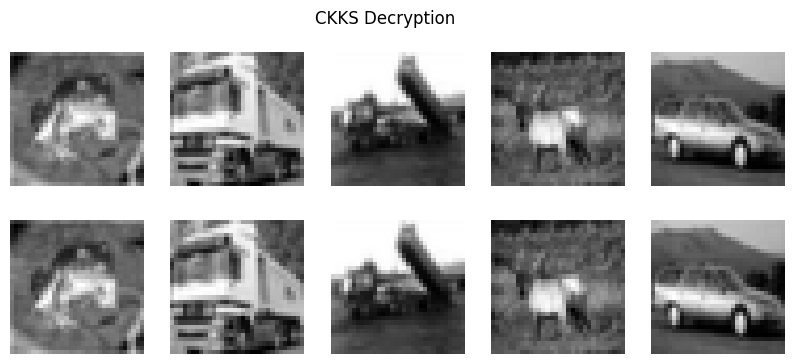

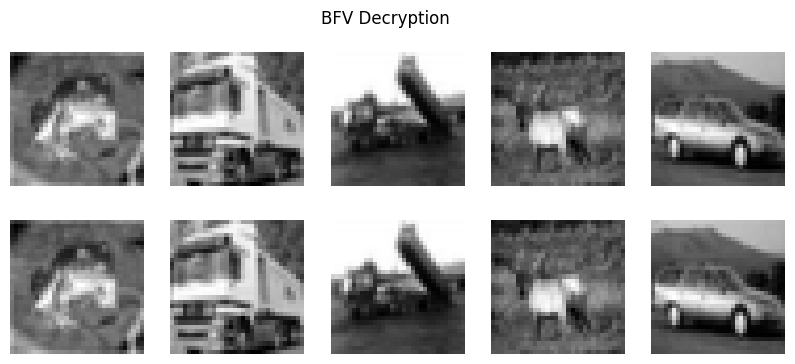

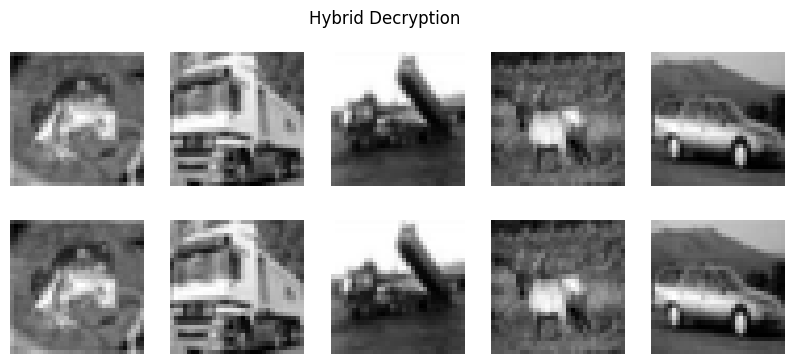

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import tenseal as ts
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
def load_cifar10_dataset():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    return trainset

# Initialize CKKS context
def ckks_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()

    data_vector = data.flatten().tolist()
    encrypted = ts.ckks_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt()).reshape(data.shape)

    return encrypted, decrypted

# Initialize BFV context
def bfv_encrypt_decrypt(data):
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=8192,
        plain_modulus=1032193,
        coeff_mod_bit_sizes=[40, 40, 40, 40]
    )
    context.generate_galois_keys()

    data_vector = (data.numpy().flatten() * 255).astype(int).tolist()
    encrypted = ts.bfv_vector(context, data_vector)
    decrypted = np.array(encrypted.decrypt()).reshape(data.shape) / 255  # Scale back

    return encrypted, decrypted

# Hybrid encryption
def hybrid_encrypt_decrypt(data):
    enc_ckks, dec_ckks = ckks_encrypt_decrypt(data)
    enc_bfv, dec_bfv = bfv_encrypt_decrypt(data)

    hybrid_decrypted = (dec_ckks + dec_bfv) / 2
    return enc_ckks, enc_bfv, hybrid_decrypted

# Display original and decrypted images
def display_images(original, decrypted, title, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    fig.suptitle(title)

    for i in range(num_images):
        axes[0, i].imshow(original[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(decrypted[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Decrypted")
    plt.show()

# Main execution
if __name__ == "__main__":
    trainset = load_cifar10_dataset()
    sample_data = torch.stack([trainset[i][0] for i in range(100)])

    print("Encrypting with CKKS...")
    encrypted_ckks, decrypted_ckks = ckks_encrypt_decrypt(sample_data)
    print("Encrypting with BFV...")
    encrypted_bfv, decrypted_bfv = bfv_encrypt_decrypt(sample_data)
    print("Performing Hybrid Encryption...")
    enc_ckks, enc_bfv, hybrid_decrypted = hybrid_encrypt_decrypt(sample_data)

    # Display images
    display_images(sample_data, decrypted_ckks, "CKKS Decryption")
    display_images(sample_data, decrypted_bfv, "BFV Decryption")
    display_images(sample_data, hybrid_decrypted, "Hybrid Decryption")